<a href = "https://www.pieriantraining.com"><img src="../PT Centered Purple.png"> </a>

<em style="text-align:center">Copyrighted by Pierian Training</em>

# Autonomous Cook - Create and visualize recipes based on your remaning food

In this project we will build a start-up that provides recipe proposals based on your remaining food.
Additionally, the final dish will be visualized so that you know what you are working for!

## Imports

In [1]:
import os
import re
import requests
import shutil

from openai import OpenAI
from PIL import Image


## OpenAI API

Remember to use the notebook as shown, you must set your OpenAI API Key as an environment variable. Obviously, there are many ways you could provide your API Key to the Python code, input() or even hard-coded, but those are typically not recommended for safety reasons. Having it as an environment variable let's the key live on the computer, but not actually be present in the code.

In [2]:
client = OpenAI()

### Tell GPT to generate a recipe
We will ask GPT to hand us a recipe based on the available ingredients. Additionally, a nice dish title should be given which we will subsequently use for visualization.

In [3]:
def create_system_prompt():
    return "You are a helpful cooking assistant."

def create_dish_prompt(list_of_ingredients):
    prompt = f"Create a detailed recipe based on only the following ingredients: {', '.join(list_of_ingredients)}.\n" \
             + f"Additionally, assign a title starting with 'Recipe Title: ' to this dish, which can be used to create a photorealistic image of it."
    return prompt

In [4]:
print(create_dish_prompt(["Eggs", "Bacon", "Cheese"]))

Create a detailed recipe based on only the following ingredients: Eggs, Bacon, Cheese.
Additionally, assign a title starting with 'Recipe Title: ' to this dish, which can be used to create a photorealistic image of it.


### OpenAI API Call
Let's use gpt-3.5-turbo to obtain the recipe based on the available food

In [5]:
system_prompt = create_system_prompt()

In [6]:
recipe_prompt = create_dish_prompt(["Eggs", "Bacon", "Cheese"])
recipe_prompt

"Create a detailed recipe based on only the following ingredients: Eggs, Bacon, Cheese.\nAdditionally, assign a title starting with 'Recipe Title: ' to this dish, which can be used to create a photorealistic image of it."

In [7]:
response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": recipe_prompt},
                ]
)


In [8]:
response

ChatCompletion(id='chatcmpl-8QVchX7GfHvwA3RmAUev0aFmB1RHK', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='Recipe Title: Cheesy Bacon and Egg Breakfast Muffins\n\nDescription: These Cheesy Bacon and Egg Breakfast Muffins are a delicious and portable breakfast option that is perfect for busy mornings. Packed with crispy bacon, gooey cheese, and wholesome eggs, they are guaranteed to satisfy your taste buds and keep you energized throughout the day.\n\nIngredients:\n- 6 slices of bacon\n- 6 large eggs\n- 1 cup shredded cheddar cheese\n- Salt and pepper, to taste\n\nInstructions:\n1. Preheat your oven to 375°F (190°C). Grease a muffin tin with cooking spray or line it with paper liners.\n\n2. In a large skillet, cook the bacon over medium heat until crispy. Transfer the cooked bacon to a plate lined with a paper towel to drain excess grease. Allow it to cool, and then crumble it into small pieces.\n\n3. In a bowl, beat the eggs until well combined. S

In [9]:
response.choices[0].message.content

'Recipe Title: Cheesy Bacon and Egg Breakfast Muffins\n\nDescription: These Cheesy Bacon and Egg Breakfast Muffins are a delicious and portable breakfast option that is perfect for busy mornings. Packed with crispy bacon, gooey cheese, and wholesome eggs, they are guaranteed to satisfy your taste buds and keep you energized throughout the day.\n\nIngredients:\n- 6 slices of bacon\n- 6 large eggs\n- 1 cup shredded cheddar cheese\n- Salt and pepper, to taste\n\nInstructions:\n1. Preheat your oven to 375°F (190°C). Grease a muffin tin with cooking spray or line it with paper liners.\n\n2. In a large skillet, cook the bacon over medium heat until crispy. Transfer the cooked bacon to a plate lined with a paper towel to drain excess grease. Allow it to cool, and then crumble it into small pieces.\n\n3. In a bowl, beat the eggs until well combined. Season with salt and pepper according to your taste preferences.\n\n4. Place a spoonful of crumbled bacon into each muffin cup, reserving some for

### Title extraction
We can now extract the title which we will feed to Dalle2 to create a beautiful visualization of our newly created recipe!

In [10]:
recipe = response.choices[0].message.content

In [11]:
def extract_title(recipe):
    return re.findall("^.*Recipe Title: .*$", recipe, re.MULTILINE)[0].strip().split("Recipe Title: ")[1]

In [12]:
extract_title(recipe)

'Cheesy Bacon and Egg Breakfast Muffins'

### Dalle3 prompt
We will now create the prompt which we pass to dalle3

In [13]:
def dalle3_prompt(recipe_title):
    prompt = f"'{recipe_title}', professional food photography, 15mm, studio lighting"
    return prompt

In [14]:
image_prompt = dalle3_prompt(extract_title(recipe))
image_prompt

"'Cheesy Bacon and Egg Breakfast Muffins', professional food photography, 15mm, studio lighting"

### Dall-E API call
We can use the client.images.generate api call to generate the image of the food.

In [15]:
response = client.images.generate(
  model="dall-e-3",
  prompt=image_prompt,
  size="1024x1024",
  quality="standard",
  n=1,
)


In [16]:
response


ImagesResponse(created=1701328833, data=[Image(b64_json=None, revised_prompt='Create a highly detailed image of Cheesy Bacon and Egg Breakfast Muffins under professional studio lighting. The photograph should have a macro perspective resembling one taken with a 15mm lens. Depict the muffins as delightfully mouth-watering, with clear visuals of the perfectly cooked bacon bits, fluffy eggs, and melting cheese adding flavor and texture to the muffins. The studio lights should highlight the textures of the muffins, enhancing the overall visual appeal of the dish.', url='https://oaidalleapiprodscus.blob.core.windows.net/private/org-FWKNS6AR0jCIQjL9hXW7WLCS/user-60RLAQMbJeZpTyjDPTF5zabx/img-xCEODJE4Z9mvDIcax9Gyxtao.png?st=2023-11-30T06%3A20%3A33Z&se=2023-11-30T08%3A20%3A33Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2023-11-29T19%3A07%3A27Z&ske=2023-11-30T19%3A07%3A27Z&sks=b&skv=2021-08-06&sig=z

In [18]:
image_url = response.data[0].url


In [19]:
def save_image(image_url, file_name):
    image_res = requests.get(image_url, stream = True)
    
    if image_res.status_code == 200:
        with open(file_name,'wb') as f:
            shutil.copyfileobj(image_res.raw, f)
    else:
        print("Error downloading image!")
    return image_res.status_code


In [20]:
save_image(image_url, "recipe.png")

200

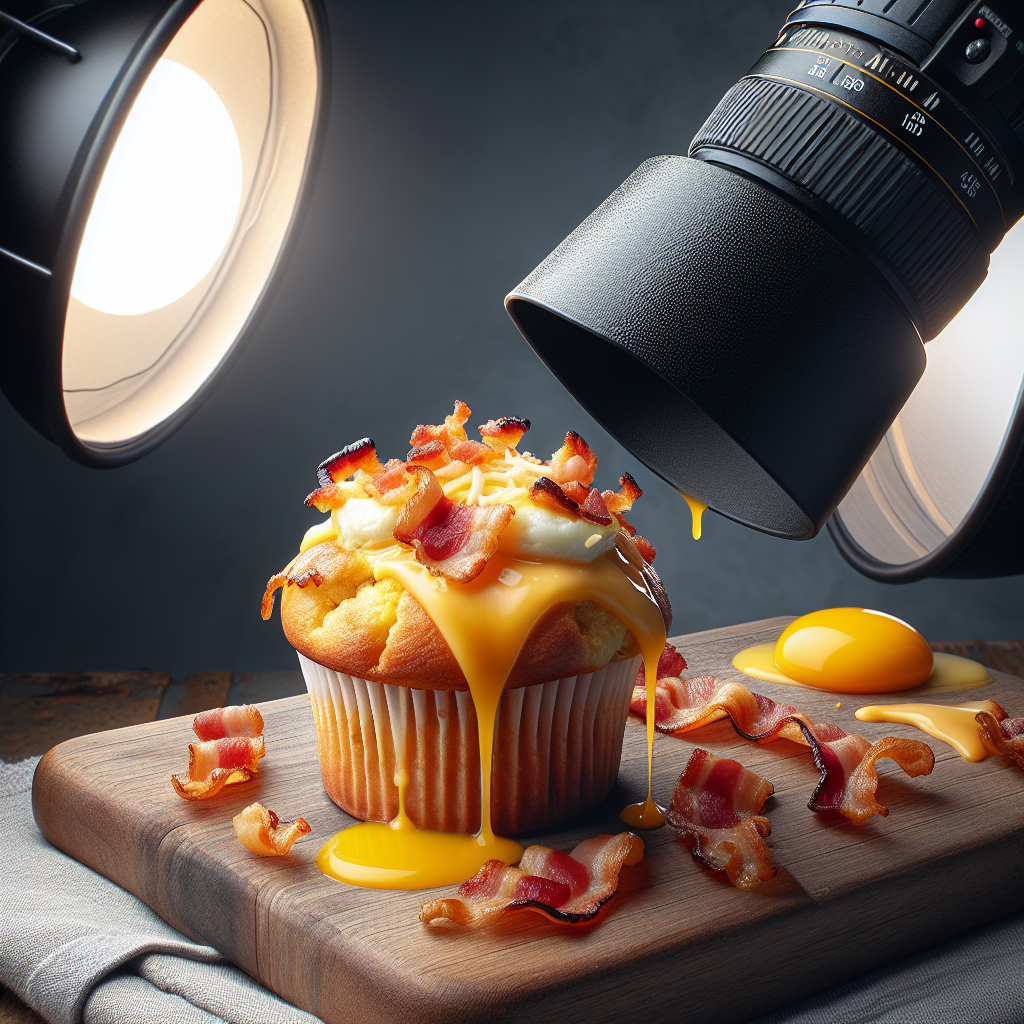

In [21]:
Image.open("recipe.png")

In [22]:
print(recipe)

Recipe Title: Cheesy Bacon and Egg Breakfast Muffins

Description: These Cheesy Bacon and Egg Breakfast Muffins are a delicious and portable breakfast option that is perfect for busy mornings. Packed with crispy bacon, gooey cheese, and wholesome eggs, they are guaranteed to satisfy your taste buds and keep you energized throughout the day.

Ingredients:
- 6 slices of bacon
- 6 large eggs
- 1 cup shredded cheddar cheese
- Salt and pepper, to taste

Instructions:
1. Preheat your oven to 375°F (190°C). Grease a muffin tin with cooking spray or line it with paper liners.

2. In a large skillet, cook the bacon over medium heat until crispy. Transfer the cooked bacon to a plate lined with a paper towel to drain excess grease. Allow it to cool, and then crumble it into small pieces.

3. In a bowl, beat the eggs until well combined. Season with salt and pepper according to your taste preferences.

4. Place a spoonful of crumbled bacon into each muffin cup, reserving some for topping. Follow t